## hammurabiX tutorial e02

### synchrotron emissivity calculation verification

In this verification, we calculate synchrotron emission with the same CRE modelling but two different inputs.

- the first input is analytic, by assuming $$ N(\gamma) = N_0 \gamma^{-\alpha} $$
- the second input is by converting the analytic one into CRE flux on discrete grid, i.e., $$ N(\gamma) = \frac{4\pi m_ec}{\beta} \Phi(E)$$

The first input does not require numeric integral over CRE energy, since the integration can be analytically derived when assuming the spectral index is locally constant.
The second input requires a numeric integral, which in essence follows the same theory as in the first casse.
To verify the methods implemented in hammurabiX, we simulate with the same models but in two ways and check if the results are identical.

The mathematical description can be found in [ApJS(2020),247,18](https://iopscience.iop.org/article/10.3847/1538-4365/ab72a2)

In [1]:
#NBVAL_CHECK_OUTPUT

import matplotlib
import numpy as np
import healpy as hp
import sys
import hampyx as hpx
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

- set CRE grid resolution

In [2]:
#NBVAL_CHECK_OUTPUT

NX = 20
NY = 20
NZ = 20
NE = 80

- write out the analytic CRE flux distribution

In [3]:
#NBVAL_CHECK_OUTPUT

def prepare_cre():
    sim = hpx.Hampyx(xml_path='../templates/params_template.xml')
    sim.del_par(['obsio', 'sync'], 'all')
    sim.del_par(['obsio', 'dm'], 'all')
    sim.del_par(['obsio', 'faraday'], 'all')

    sim.del_par(['cremodel'], 'all')
    sim.add_par([],'cremodel')
    sim.add_par(['cremodel'], 'unif', {'cue': str(1)})
    sim.add_par(['cremodel','unif'],'alpha', {'value': str(3)})
    sim.add_par(['cremodel','unif'],'r0', {'value': str(5)})
    sim.add_par(['cremodel','unif'],'e0', {'value': str(20.6)})
    sim.add_par(['cremodel','unif'],'j0', {'value': str(0.0217)})
    
    sim.mod_par(['fieldio','crefield'],{'write':'1','read':'0'})
    sim.mod_par(['grid','crefield','nx'],{'value':str(NX)})
    sim.mod_par(['grid','crefield','ny'],{'value':str(NY)})
    sim.mod_par(['grid','crefield','nz'],{'value':str(NZ)})
    sim.mod_par(['grid','crefield','ne'],{'value':str(NE)})
    sim.mod_par(['grid', 'crefield', 'x_min'], {'value': '-13'})
    sim.mod_par(['grid', 'crefield', 'x_max'], {'value': '-4'})
    sim.mod_par(['grid', 'crefield', 'y_min'], {'value': '-2'})
    sim.mod_par(['grid', 'crefield', 'y_max'], {'value': '2'})
    sim.mod_par(['grid', 'crefield', 'z_min'], {'value': '-4'})
    sim.mod_par(['grid', 'crefield', 'z_max'], {'value': '4'})
    sim.mod_par(['grid', 'crefield', 'e_min'], {'value': '0.1'})
    sim.mod_par(['grid', 'crefield', 'e_max'], {'value': '100'})

    sim()
    
prepare_cre()

- read in the CRE grid and simulate synchrotron emission

In [4]:
#NBVAL_CHECK_OUTPUT

def simulator_crenum(nside,b0,freq):
    sim = hpx.Hampyx(xml_path='../templates/params_template.xml')
    sim.del_par(['obsio', 'sync'], 'all')
    sim.add_par(['obsio'], 'sync', {'cue': str(1), 'freq': str(freq), 'nside': str(nside)})
    sim.del_par(['obsio', 'dm'], 'all')
    sim.del_par(['obsio', 'faraday'], 'all')
    
    sim.mod_par(['grid','shell'], {'type': 'auto'})
    sim.mod_par(['grid','shell', 'auto', 'shell_num'], {'value': str(1)})
    sim.mod_par(['grid','shell', 'auto', 'nside_sim'], {'value': str(nside)})
    sim.mod_par(['grid','shell','oc_r_res'], {'value': str(0.005)})
    sim.mod_par(['grid','shell','oc_r_max'], {'value': str(2.0)})
    sim.mod_par(['grid','shell','oc_r_min'], {'value': str(0.5)})
    
    sim.del_par(['bmodel'], 'all')
    sim.add_par([],'bmodel')
    sim.add_par(['bmodel'], 'unif', {'cue': str(1)})
    sim.add_par(['bmodel', 'unif'], 'bp', {'value': str(b0)})
    sim.add_par(['bmodel', 'unif'], 'l0', {'value': str(70)})
    sim.add_par(['bmodel', 'unif'], 'bv', {'value': str(0)})

    sim.mod_par(['grid','shell','gc_z_min'], {'value': '-4'})
    sim.mod_par(['grid','shell','gc_z_max'], {'value': '4'})

    sim.del_par(['temodel'], 'all')
    sim.add_par([],'temodel')
    sim.add_par(['temodel'], 'unif', {'cue': str(1)})
    sim.add_par(['temodel', 'unif'], 'n0', {'value': str(0.01)})
    sim.add_par(['temodel', 'unif'], 'r0', {'value': str(4)})

    sim.mod_par(['fieldio','crefield'],{'read':'1', 'write':'0'})
    sim.mod_par(['grid','crefield','nx'],{'value':str(NX)})
    sim.mod_par(['grid','crefield','ny'],{'value':str(NY)})
    sim.mod_par(['grid','crefield','nz'],{'value':str(NZ)})
    sim.mod_par(['grid','crefield','ne'],{'value':str(NE)})
    sim.mod_par(['grid', 'crefield', 'x_min'], {'value': '-11'})
    sim.mod_par(['grid', 'crefield', 'x_max'], {'value': '-5'})
    sim.mod_par(['grid', 'crefield', 'y_min'], {'value': '-2'})
    sim.mod_par(['grid', 'crefield', 'y_max'], {'value': '2'})
    sim.mod_par(['grid', 'crefield', 'z_min'], {'value': '-4'})
    sim.mod_par(['grid', 'crefield', 'z_max'], {'value': '4'})
    sim.mod_par(['grid', 'crefield', 'e_min'], {'value': '0.1'})
    sim.mod_par(['grid', 'crefield', 'e_max'], {'value': '100'})

    sim()

    q = sim.sim_map[('sync', str(freq), str(nside), 'Q')]*1000
    u = sim.sim_map[('sync', str(freq), str(nside), 'U')]*1000
    i = sim.sim_map[('sync', str(freq), str(nside), 'I')]*1000
    return (i,q,u)


NSIDE = 16
B0 = 2.
FREQ = 30.
rslt_num = simulator_crenum(NSIDE, B0, FREQ)

- calculate synchrotron emission with the same settings but with analytic CRE distribution

In [5]:
#NBVAL_CHECK_OUTPUT

def simulator_creana(nside,b0,freq):
    sim = hpx.Hampyx(xml_path='../templates/params_template.xml')
    sim.del_par(['obsio', 'sync'], 'all')
    sim.add_par(['obsio'], 'sync', {'cue': str(1), 'freq': str(freq), 'nside': str(nside)})
    sim.del_par(['obsio', 'dm'], 'all')
    sim.del_par(['obsio', 'faraday'], 'all')
    
    sim.mod_par(['grid','shell'], {'type': 'auto'})
    sim.mod_par(['grid','shell', 'auto', 'shell_num'], {'value': str(1)})
    sim.mod_par(['grid','shell', 'auto', 'nside_sim'], {'value': str(nside)})
    sim.mod_par(['grid','shell','oc_r_res'], {'value': str(0.005)})
    sim.mod_par(['grid','shell','oc_r_max'], {'value': str(2.0)})
    sim.mod_par(['grid','shell','oc_r_min'], {'value': str(0.5)})
    
    sim.del_par(['bmodel'], 'all')
    sim.add_par([],'bmodel')
    sim.add_par(['bmodel'], 'unif', {'cue': str(1)})
    sim.add_par(['bmodel', 'unif'], 'bp', {'value': str(b0)})
    sim.add_par(['bmodel', 'unif'], 'l0', {'value': str(70)})
    sim.add_par(['bmodel', 'unif'], 'bv', {'value': str(0)})

    sim.mod_par(['grid','shell','gc_z_min'], {'value': '-4'})
    sim.mod_par(['grid','shell','gc_z_max'], {'value': '4'})

    sim.del_par(['temodel'], 'all')
    sim.add_par([],'temodel')
    sim.add_par(['temodel'], 'unif', {'cue': str(1)})
    sim.add_par(['temodel', 'unif'], 'n0', {'value': str(0.01)})
    sim.add_par(['temodel', 'unif'], 'r0', {'value': str(4)})
    
    sim.del_par(['cremodel'], 'all')
    sim.add_par([],'cremodel')
    sim.add_par(['cremodel'], 'unif', {'cue': str(1)})
    sim.add_par(['cremodel', 'unif'], 'alpha', {'value': str(3)})
    sim.add_par(['cremodel', 'unif'], 'r0', {'value': str(5)})
    sim.add_par(['cremodel','unif'],'e0', {'value': str(20.6)})
    sim.add_par(['cremodel','unif'],'j0', {'value': str(0.0217)})
    
    sim()

    q = sim.sim_map[('sync', str(freq), str(nside), 'Q')]*1000
    u = sim.sim_map[('sync', str(freq), str(nside), 'U')]*1000
    i = sim.sim_map[('sync', str(freq), str(nside), 'I')]*1000
    return (i,q,u)


rslt_ana = simulator_creana(NSIDE, B0, FREQ)

- compare results from two cases

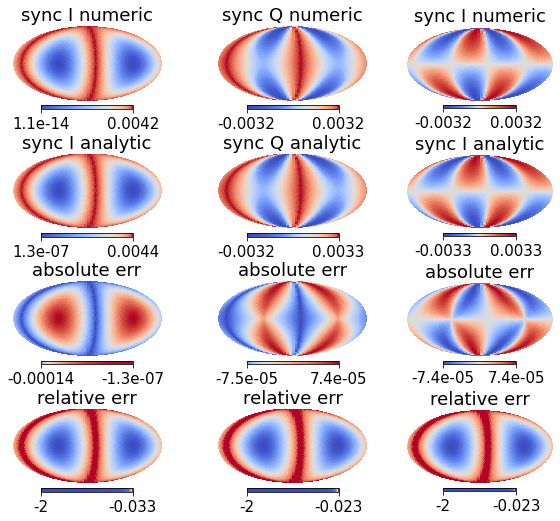

In [6]:
#NBVAL_CHECK_OUTPUT

matplotlib.rcParams.update({'font.size': 15})
colormap=matplotlib.cm.coolwarm;
colormap.set_under("white");
colormap.set_bad("white")

fig = matplotlib.pyplot.figure(figsize=(10,10))

gs = matplotlib.gridspec.GridSpec(30, 30)

fig.add_subplot(gs[0:5, 0:10])
hp.mollview(rslt_num[0],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='sync I numeric',cbar=1)
fig.add_subplot(gs[7:12, 0:10])
hp.mollview(rslt_ana[0],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='sync I analytic',cbar=1)
fig.add_subplot(gs[14:19, 0:10])
hp.mollview(rslt_num[0]-rslt_ana[0],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='absolute err',cbar=1)
fig.add_subplot(gs[21:26, 0:10])
hp.mollview(2.*(rslt_num[0]-rslt_ana[0])/(rslt_num[0]+rslt_ana[0]),format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='relative err',cbar=1)


fig.add_subplot(gs[0:5, 11:21])
hp.mollview(rslt_num[1],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='sync Q numeric',cbar=1)
fig.add_subplot(gs[7:12, 11:21])
hp.mollview(rslt_ana[1],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='sync Q analytic',cbar=1)
fig.add_subplot(gs[14:19, 11:21])
hp.mollview(rslt_num[1]-rslt_ana[1],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='absolute err',cbar=1)
fig.add_subplot(gs[21:26, 11:21])
hp.mollview(2.*(rslt_num[1]-rslt_ana[1])/(rslt_num[1]+rslt_ana[1]),format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='relative err',cbar=1)


fig.add_subplot(gs[0:5, 22:32])
hp.mollview(rslt_num[2],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='sync I numeric',cbar=1)
fig.add_subplot(gs[7:12, 22:32])
hp.mollview(rslt_ana[2],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='sync I analytic',cbar=1)
fig.add_subplot(gs[14:19, 22:32])
hp.mollview(rslt_num[2]-rslt_ana[2],format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='absolute err',cbar=1)
fig.add_subplot(gs[21:26, 22:32])
hp.mollview(2.*(rslt_num[2]-rslt_ana[2])/(rslt_num[2]+rslt_ana[2]),format='%.2g',
            norm='hist',cmap='coolwarm',hold=True,title='relative err',cbar=1)

clean up

In [7]:
import os
if os.path.isfile('err.log'):
    os.remove('err.log')
if os.path.isfile('run.log'):
    os.remove('run.log')
if os.path.isfile('cre.bin'):
    os.remove('cre.bin')

end